# NERfR (Named Entity Recognition for Recipes)

Using TASTEset, SpaCy, and recipes_scrapers

## Installations and Imports

In [ ]:
!git clone https://github.com/taisti/TASTEset
%cd TASTEset
!pip install -r requirements.txt
# For some reason, the requirements don't all install when you run
# `pip install -r requirements.txt`, so we'll need to install `nervaluate`
# explicitly.
!pip install nervaluate

import spacy
from src.utils import prepare_data, ENTITIES

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Data Preparation

## Using the TASTEset Utilities

Fortunately, this repo comes with helper functions that do a good deal of the data preparation. If you want to have a better look at what's happening, check out the `src/utils.py` file, or the raw data `.csv` file in `data/TASTEset.csv`.

The utility function we'll be using is `prepare_data`, which outputs:
1. `recipes: list[str]`: a list of the plain text recipes, and
2. `entities: list[list[tuple[int, int, str]]]`: Is that typehint hard to read? It's a list, where each item contains the entity labels of the recipe in `recipes` at the corresponsing index. One *entity* is formatted as a `tuple` containing the start index, end index, and label for the given entity. I'll illustrate that more clearly below.

In [ ]:
recipes, entities = prepare_data("data/TASTEset.csv")

# Here's the first recipe in our dataset
recipes[0]

'5 ounces rum\n4 ounces triple sec\n3 ounces Tia Maria\n20 ounces orange juice\n'

In [ ]:
# Let's also have a look at the set of entities/classes
ENTITIES

['FOOD',
 'QUANTITY',
 'UNIT',
 'PROCESS',
 'PHYSICAL_QUALITY',
 'COLOR',
 'TASTE',
 'PURPOSE',
 'PART']

In [ ]:
# Let's check out the entity labels for that first recipe
entities[0]

[(0, 1, 'QUANTITY'),
 (2, 8, 'UNIT'),
 (9, 12, 'FOOD'),
 (13, 14, 'QUANTITY'),
 (15, 21, 'UNIT'),
 (22, 32, 'FOOD'),
 (33, 34, 'QUANTITY'),
 (35, 41, 'UNIT'),
 (42, 51, 'FOOD'),
 (52, 54, 'QUANTITY'),
 (55, 61, 'UNIT'),
 (62, 74, 'FOOD')]

In [ ]:
# So, for example, if we want to grab each entity from the first recipe and
# it's corresponding label

[f"{recipes[0][start:end]}: {ent}" for start, end, ent in entities[0]]

['5: QUANTITY',
 'ounces: UNIT',
 'rum: FOOD',
 '4: QUANTITY',
 'ounces: UNIT',
 'triple sec: FOOD',
 '3: QUANTITY',
 'ounces: UNIT',
 'Tia Maria: FOOD',
 '20: QUANTITY',
 'ounces: UNIT',
 'orange juice: FOOD']

### Prepping the code for spaCy

We're going to be following [the pipeline training tutorial from spaCy's documentation](https://spacy.io/usage/training). I'll give you a quick explanation if I deviate from the docs or make any calls of my own.

For formatting, we'll need  things:

1. `annotations`, which is a list of `dict`s shaped as follows:
```
{
  'text': list[str],
  'entities': list[tuple[int, int, str]]
}
```
`text` is the recipes. Here I joined them at the newline character, since that's how the authors went about it in their training script.
`entities` is just the list of entities for the recipe in `text`.
2. `classes`, which is the flat list of possible entities.

In [ ]:
annotations = [{'text': ' '.join(recipe.splitlines()), 'entities': ents} for recipe, ents in zip(recipes, entities)]
training_data = {'classes': ENTITIES, 'annotations': annotations}

In [ ]:
# This is taken more-or-less verbatim from the docs:
# https://spacy.io/usage/training#training-data
from spacy.tokens import DocBin

nlp = spacy.blank("en")

def doc_from_annotations(annotations):

  doc_bin = DocBin()

  for example in annotations:
    doc = nlp.make_doc(example['text'])
    ents = []
    for entity in example['entities']:
      span = doc.char_span(*entity)
      ents.append(span)

    doc.ents = ents
    doc_bin.add(doc)
  return doc_bin

The train/test split is pretty project specific. I went with an 80/20 split for training/testing data. I'll say that anecdotally, it seems like the de-facto standard, and I was happy with the results.

In [ ]:
# Let's get ourselves an 80/20 split.
train_len = int(0.8*len(annotations))
train_len

560

We're saving the training data as `.spacy` files to the main directory. Feel free to move this around to fit your purposes.

In [ ]:
%cd /content

train_bin = doc_from_annotations(annotations[:train_len])
dev_bin = doc_from_annotations(annotations[train_len:])

train_bin.to_disk("nerfr_train.spacy")
dev_bin.to_disk("nerfr_dev.spacy")

/content


### Training Config
Again, this is swiped from [the docs](https://spacy.io/usage/training#quickstart). The tutorial has you save the config as a text file with a `.cfg` extension. Here are the parameters I went with:

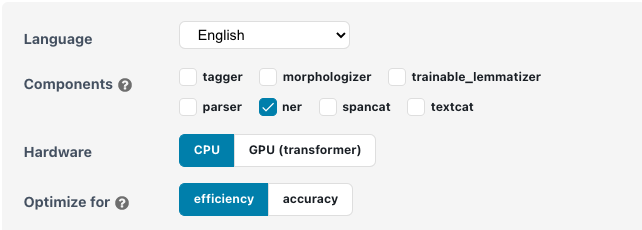

I copy/pasted the generated config below. Note that I also added the paths to the train and test datasets on lines 2 and 3. You'll want to adjust that as needed.

In [ ]:
# Base config for efficiency optimization

# This is an auto-generated partial config. To use it with 'spacy train'
# you can run spacy init fill-config to auto-fill all default settings:
# python -m spacy init fill-config ./base_config.cfg ./config.cfg
BASE_CONFIG = """[paths]
train = nerfr_train.spacy
dev = nerfr_dev.spacy
vectors = null
[system]
gpu_allocator = null

[nlp]
lang = "en"
pipeline = ["tok2vec","ner"]
batch_size = 1000

[components]

[components.tok2vec]
factory = "tok2vec"

[components.tok2vec.model]
@architectures = "spacy.Tok2Vec.v2"

[components.tok2vec.model.embed]
@architectures = "spacy.MultiHashEmbed.v2"
width = ${components.tok2vec.model.encode.width}
attrs = ["NORM", "PREFIX", "SUFFIX", "SHAPE"]
rows = [5000, 1000, 2500, 2500]
include_static_vectors = false

[components.tok2vec.model.encode]
@architectures = "spacy.MaxoutWindowEncoder.v2"
width = 96
depth = 4
window_size = 1
maxout_pieces = 3

[components.ner]
factory = "ner"

[components.ner.model]
@architectures = "spacy.TransitionBasedParser.v2"
state_type = "ner"
extra_state_tokens = false
hidden_width = 64
maxout_pieces = 2
use_upper = true
nO = null

[components.ner.model.tok2vec]
@architectures = "spacy.Tok2VecListener.v1"
width = ${components.tok2vec.model.encode.width}

[corpora]

[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0

[training]
dev_corpus = "corpora.dev"
train_corpus = "corpora.train"

[training.optimizer]
@optimizers = "Adam.v1"

[training.batcher]
@batchers = "spacy.batch_by_words.v1"
discard_oversize = false
tolerance = 0.2

[training.batcher.size]
@schedules = "compounding.v1"
start = 100
stop = 1000
compound = 1.001

[initialize]
vectors = ${paths.vectors}
"""

with open("base_config.cfg", 'w') as f:
  f.write(BASE_CONFIG)

In [ ]:
# This command fills in your config with from the base_config you generated. The
# last argument is the name of your config. I used "_eff" for "efficiency". Feel
# free to change that
!python -m spacy init fill-config /content/base_config.cfg config_eff.cfg

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-01-14 11:45:13.239086: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
✔ Auto-filled config with all values
✔ Saved config
config_eff.cfg
You can now add your data and train your pipeline:
python -m spacy train config_eff.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


## Training

Run the following code to train! Note that you'll have to change the path and name of the `.cfg` file as necessary. The last argument is a folder that'll contain your pipeline. Feel free to prefix it with a path to a more useful location. Also have some fun with the name!

You'll get periodic updates with the `loss`, `F1`, `precision`, `recall` for the NER model over time. They also give you a `SCORE`, which is helpful when training multiple components, but in our case, the `SCORE` is just the `F1` score for the NER model.

In [ ]:
!python -m spacy train config_eff.cfg --output output_eff

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-01-14 11:46:26.019013: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
✔ Created output directory: drive/MyDrive/output_eff
ℹ Saving to output directory: drive/MyDrive/output_eff
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2023-01-14 11:46:27,042] [INFO] Set up nlp object from config
INFO:spacy:Set up nlp object from config
[2023-01-14 11:46:27,059] [INFO] Pipeline: ['tok2vec', 'ner']
INFO:spacy:Pipeline: ['tok2vec', 'ner']
[2023-01-14 11:46:27,063] [INFO] Created vocabulary
INFO:spacy:Created vocabulary
[2023-01-14 11:46:27,064] [INFO] Finished initializing nlp object
INFO:spacy:Finished initializing nlp object
[2023-01-14 11:46:27,634] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
INFO:spacy:In

## Results

The training outputs a `meta.json` file in the output folder (`output_eff` in our case). We can use this to check a number of metrics, including the performance of each entity class.

In [ ]:
import json
import pandas as pd

# grab the performance dict from within the meta file
performance = json.load(open("/content/output_eff/model-best/meta.json", 'r'))['performance']
performance_by_ent = performance['ents_per_type']

In [ ]:
perf_df = pd.DataFrame(performance_by_ent)
perf_df["TOTAL"] = [performance['ents_p'], performance['ents_r'], performance['ents_f']]

# display df with the cell color corresponding to the value (dark=high; light=low)
perf_df.style.background_gradient(
    axis=1, low=perf_df.min().min(), high=1, cmap='YlOrBr'
    )

,PHYSICAL_QUALITY,FOOD,QUANTITY,UNIT,COLOR,PART,TASTE,PROCESS,PURPOSE,TOTAL
p,0.798742,0.878294,0.976096,0.981848,0.893617,0.857143,0.695652,0.903930,0.777778,0.925856
r,0.814103,0.873908,0.982620,0.962783,0.857143,0.400000,0.800000,0.884615,0.636364,0.918175
f,0.806349,0.876095,0.979347,0.972222,0.875000,0.545455,0.744186,0.894168,0.700000,0.921999


Here we've got the precision (p), recall (r), and F1 (f) score by entity. It seems like the best performing entities are the ones we care the most about. Only 40% of *PART* entities are being turned up. I can live with that.

## Getting the Confusion Matrix

We're going to be plotting a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) on the same test set we used for training. At a high level, this entails running each sample through the trained model, and, for each token, storing the entity the model predicted for that token, as well as the ground truth entity (as labeled by the dataset authors).

In [ ]:
# load the model and test set. Again, change the paths as required
nlp = spacy.load('/content/output_eff/model-best')
test_set = list(DocBin().from_disk("nerfr_dev.spacy").get_docs(nlp.vocab))

In [ ]:
pred_ents = []
true_ents = []

for recipe in test_set:
  # tok.ent_type_ gets the ent per token, as opposed to breaking the Doc into
  # entities. This ensures that `true_ents` and `pred_ents` are the same length.
  true_ents += [tok.ent_type_ for tok in recipe]
  # `recipe.text` grabs the raw recipe, because `recipe` already contains entity
  # labels.
  pred_ents += [tok.ent_type_ for tok in nlp(recipe.text)]

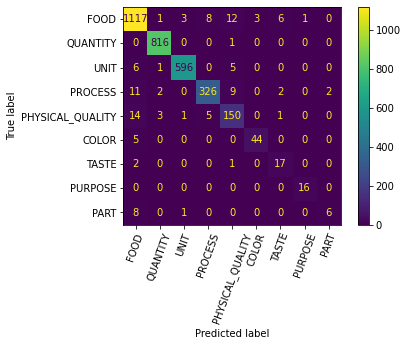

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# create and display the confusion matrix
cm = confusion_matrix(true_ents, pred_ents, labels=ENTITIES)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ENTITIES)

disp.plot()
plt.xticks(rotation=70)
plt.show()

Unfortunately, there isn't quite enough data for the color mapping to show fine-grained differences. Nonetheless, we can get a sense for the more common mislabelings.

## Inference

Let's test this baby out!

You'll notice I load the recipes as lists of ingredient lines and run each ingredient line through the pipeline separately, even though we trained the models on recipes
I found it performed better this way, despite the formatting mismatch.

In [ ]:
!pip install recipe-scrapers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.6/158.6 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 KB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.3/500.3 KB 15.7 MB/s eta 0:00:00
  Created wheel for jstyleson: filename=jstyleson-0.0.2-py3-none-any.whl size=2401 sha256=20d97d60332c02be41395b980e468cf1cfd2a3f9140b84a1766fb2b974832901
  Stored in directory: /root/.cache/pip/wheels/c6/3a/8e/dad087c08bb0e4c94d03433ccc0972ee29707dff8e6c5f5e1b
  Created wheel for mf2py: filename=mf2py-1.1.2-py3-none-any.whl size=23242 sha256=2cdcc52b5e947635cfe77bcf7ac102a5aa9b5fb357d151b100e769781d153040
  Sto

In [ ]:
from recipe_scrapers import scrape_me

RECIPE_URL = "https://www.allrecipes.com/recipe/246868/pecan-sour-cream-coffee-cake/"
scraper = scrape_me(RECIPE_URL)
scraper.ingredients()

['1.5 cups pecans, finely chopped',
 '0.33333334326744 cup white sugar',
 '0.33333334326744 cup packed light brown sugar',
 '3 tablespoons melted butter',
 '1 teaspoon cinnamon',
 '0.125 teaspoon salt',
 '1.875 cups all-purpose flour',
 '1 teaspoon baking powder',
 '0.75 teaspoon baking soda',
 '0.5 teaspoon fine sea salt',
 '1 cup white sugar',
 '0.5 cup unsalted butter, softened',
 '2 large eggs',
 '1 cup sour cream or creme fraiche',
 '1.5 teaspoons vanilla extract']

### Text Pre-Processing Function

Note the float representations of ingredient quantities, in spite of the fact that the website shows them in mixed numbers.

In [ ]:
from fractions import Fraction
import re


def fraction_to_mixed_number(fraction: Fraction) -> str:
  if fraction.numerator >= fraction.denominator:
    whole, remainder = divmod(fraction.numerator, fraction.denominator)
    if remainder == 0:
      return str(whole)
    else:
      return f"{whole} {Fraction(remainder, fraction.denominator)}"
  else:
    return str(fraction)


def convert_floats_to_fractions(text: str) -> str:
    return re.sub(
        r'\b-?\d+\.\d+\b',
        lambda match: fraction_to_mixed_number(
            Fraction(float(match.group())).limit_denominator()), text
        )


def process_text(text):
  """
  A wrapper function to pre-process text and run it through our pipeline.
  """
  return nlp(convert_floats_to_fractions(text))

In [ ]:
# Let's have a look at our processing fucntion at work
[convert_floats_to_fractions(line) for line in scraper.ingredients()]

['1 1/2 cups pecans, finely chopped',
 '1/3 cup white sugar',
 '1/3 cup packed light brown sugar',
 '3 tablespoons melted butter',
 '1 teaspoon cinnamon',
 '1/8 teaspoon salt',
 '1 7/8 cups all-purpose flour',
 '1 teaspoon baking powder',
 '3/4 teaspoon baking soda',
 '1/2 teaspoon fine sea salt',
 '1 cup white sugar',
 '1/2 cup unsalted butter, softened',
 '2 large eggs',
 '1 cup sour cream or creme fraiche',
 '1 1/2 teaspoons vanilla extract']

### Running Inference with Processing

In [ ]:
# Load the model again for good measure
nlp = spacy.load('/content/output_eff/model-best')

from spacy import displacy

In [ ]:
# process the recipe, line-by-line
docs = [process_text(line) for line in scraper.ingredients()]

displacy.render(docs, style="ent", jupyter=True)

In [ ]:
PREPPY_URL = 'https://preppykitchen.com/coffee-cake/'
scraper = scrape_me(PREPPY_URL, wild_mode=True)
scraper.ingredients()

['3/4 cup light brown sugar (150g)',
 '1/4 cup all purpose flour (30g)',
 '2 tsp ground cinnamon',
 '2/3 cup light brown sugar (133g, lightly packed)',
 '1 cup all-purpose flour (120g)',
 '2 tsp ground cinnamon',
 '¼ tsp salt',
 '1/2 cup unsalted butter (113g, diced)',
 '2 1/4 cup all-purpose flour ( 270g)',
 '1/4 cup cornstarch (30g)',
 '2 ½ tsp baking powder',
 '3/4 tsp salt',
 '¾ cup unsalted butter (170, at room temperature)',
 '1/2 cup brown sugar (100g)',
 '1 cup granulated sugar (200g)',
 '3 eggs (room temperature, large)',
 '2 tsp vanilla extract (10mL)',
 '1 cup sour cream (240mL, room temperature)']

In [ ]:
# process the recipe, line-by-line
docs = [process_text(line) for line in scraper.ingredients()]

displacy.render(docs, style="ent", jupyter=True)

And that's all folks! Feel free to use this code for your own purposes, and happy parsing!